## Resting EEG Periodic, Aperiodic Measures and Cognitive Performance: Effects of Multimodal Lifestyle Intervention in Healthy Ageing *[WORKING TITLE]*

Created by Alicia J. Campbell

In [301]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
from tableone import TableOne
from scipy import stats
from scipy.stats import zscore
import pingouin as pg
import os
import warnings
import patsy

warnings.simplefilter(action='ignore')

In [ ]:
cwd = os.getcwd()

plots_dir = os.path.join(cwd, 'results', 'plots')
os.makedirs(plots_dir, exist_ok=True)

fnames = [
    'data/LEISURE_DEMO_T1_T2_T3_CONCAT.xlsx',
    'data/LEISURE_CANTAB_T1_T2_T3_CONCAT.xlsx',
    'data/LEISURE_SART_T1_T2_T3_CONCAT.xlsx',
    'data/LEISURE_rsEEG_EC_T1_T2_T3_CONCAT.xlsx'
]

df = pd.DataFrame()
for i, fname in enumerate(fnames):
    df_t = pd.read_excel(os.path.join(cwd, fname))
    df_t.columns = df_t.columns.str.replace(" ", "_")
    df_t.columns = df_t.columns.str.replace("(", "_")
    df_t.columns = df_t.columns.str.replace(")", "_")
    df_t.columns = df_t.columns.str.replace("-", "_")
    if i == 0:
        df = df_t.copy()
    else:
        df = df.merge(df_t, on=['subject', 'tp'], how='outer')

df = df.dropna(subset='EEG_date')
for tp in [1, 2, 3]:
    print(f'tp={tp}')
    print(len(df[df['tp']==tp]))

In [ ]:
from scipy.stats import fisher_exact

df_dc = df.copy()
df_dc['gender_f'] = df_dc['gender_f'].map({0.0: 'M', 1.0: 'F'})
df_dc['handedness_r'] = df_dc['handedness_r'].map({0.0: 'L', 1.0: 'R'})

vars_all = {
    'age': 'Age', 
    'gender_f': 'Gender', 
    'handedness_r': 'Handedness', 
    'education': 'Education',
    'DMSPCAD': 'DMS PCAD', 
    'PALTEA': 'PALTEA',
    'RVPA': 'RVP A', 
    'SWMBE': 'SWMBE', 
    'd_prime': ["SART D'"], 
    'exponent_po': 'Parieto-occipital exponent', 
    'iaf_po': 'Parieto-occipital IAF', 
    'exponent_fc': 'Fronto-central exponent', 
    'iaf_fc': 'Fronto-central IAF'
}

# Print missing values
df_subset = df_dc[df_dc['tp']==3]
for column in vars_all.keys():
    missing = df_subset[df_subset[column].isna()]
    if len(missing) > 0:
        print(f"\nMissing values in {vars_all[column]}:")
        for _, row in missing.iterrows():
            print(f"Subject {row['subject']}")
            
vars_cat = ['handedness_r', 'gender_f']
vars_notnorm = ['education']

table = TableOne(
    # data
    data=df_subset,
    groupby='group_life',
    columns=list(vars_all.keys()),
    categorical=vars_cat,
    include_null=True,
    # visual
    rename=vars_all,
    decimals=1,
    label_suffix=True,
    missing=True,
    overall=True,
    # tests
    dip_test=True,
    normal_test=True,
    tukey_test=True,
    # stats
    nonnormal=vars_notnorm,
    htest_name=True,
    pval=True, 
    pval_adjust=None
)

# table.to_excel('results/descriptives_T1.xlsx')

display(table)

# # Create contingency table (just for T1)

# contingency = pd.crosstab(df_subset['group_life'], df_subset['handedness_r'])
# _, pval = fisher_exact(contingency)

# print("Contingency Table:")
# print(contingency)
# print(f"\nFisher's exact test p-value: {pval:.3f}")

### Visualisation of raw and outliers

In [119]:
variables_of_interest = [ 
    'DMSPCAD', 'PALTEA', 'RVPA', 'SWMBE', 'd_prime', 'exponent_po', 'iaf_po', 'exponent_fc', 'iaf_fc']

Boxplots

In [ ]:
n_vars = len(variables_of_interest)
n_cols = 4  # Fixed to 2 columns
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
axes = axes.flatten()

for idx, var in enumerate(variables_of_interest):
    data = [df[df['tp'] == tp][var].dropna() for tp in df['tp'].unique()]
    
    if any(len(d) > 0 for d in data):
        # Create boxplot
        bplot = axes[idx].boxplot(data, labels=df['tp'].unique(), patch_artist=True)
        
        # Add individual points with jitter
        for i, d in enumerate(data):
            # Create jitter
            x = np.random.normal(i + 1, 0.04, size=len(d))
            axes[idx].plot(x, d, 'o', alpha=0.5, color='navy', markersize=2)
        
        # Customize the box colors
        for patch in bplot['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)
    
    axes[idx].set_title(var)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, linestyle='--', alpha=0.7)

# Remove empty subplots if any
for idx in range(len(variables_of_interest), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [ ]:
n_vars = len(variables_of_interest)
n_cols = 4  # Fixed to 2 columns
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
axes = axes.flatten()

for idx, var in enumerate(variables_of_interest):
    data = [df[df['tp'] == tp][var].dropna() for tp in df['tp'].unique()]
    
    if any(len(d) > 0 for d in data):
        # Create boxplot without outliers first
        bplot = axes[idx].boxplot(data, labels=df['tp'].unique(), patch_artist=True, 
                                showfliers=False)  # Hide outliers initially
        
        # Process outliers for each timepoint
        for i, tp in enumerate(df['tp'].unique()):
            tp_data = df[df['tp'] == tp].dropna(subset=[var])
            
            # Skip if not enough data points for meaningful statistics
            if len(tp_data) < 4:
                continue
                
            values = tp_data[var].values
            q1 = np.nanpercentile(values, 25)
            q3 = np.nanpercentile(values, 75)
            iqr = q3 - q1
            
            # Define boundaries
            mild_upper = q3 + 1.5 * iqr
            mild_lower = q1 - 1.5 * iqr
            extreme_upper = q3 + 3 * iqr
            extreme_lower = q1 - 3 * iqr
            
            # Corrected outlier classification
            mild_outliers = values[
                ((values > mild_upper) & (values <= extreme_upper)) |
                ((values < mild_lower) & (values >= extreme_lower))
            ]
            extreme_outliers = values[
                (values > extreme_upper) | (values < extreme_lower)
            ]
            
            # Plot mild outliers in orange
            if len(mild_outliers) > 0:
                axes[idx].plot([i + 1] * len(mild_outliers), mild_outliers, 
                             'o', color='orange', label='Mild outlier' if i == 0 else "")
                
                # Label mild outliers
                for outlier in mild_outliers:
                    subject_id = tp_data[tp_data[var] == outlier]['subject'].values
                    if len(subject_id) > 0:
                        axes[idx].annotate(str(subject_id[0]), 
                                         xy=(i + 1, outlier),
                                         xytext=(10, 0), 
                                         textcoords='offset points',
                                         ha='left', va='center',
                                         color='blue', fontsize=8,
                                         arrowprops=dict(arrowstyle='-',
                                                       color='gray',
                                                       alpha=0.5))
            
            # Plot extreme outliers in red
            if len(extreme_outliers) > 0:
                axes[idx].plot([i + 1] * len(extreme_outliers), extreme_outliers, 
                             'o', color='red', label='Extreme outlier' if i == 0 else "")
                
                # Label extreme outliers
                for outlier in extreme_outliers:
                    subject_id = tp_data[tp_data[var] == outlier]['subject'].values
                    if len(subject_id) > 0:
                        axes[idx].annotate(str(subject_id[0]), 
                                         xy=(i + 1, outlier),
                                         xytext=(10, 0), 
                                         textcoords='offset points',
                                         ha='left', va='center',
                                         color='blue', fontsize=8,
                                         arrowprops=dict(arrowstyle='-',
                                                       color='gray',
                                                       alpha=0.5))
        
        # # Add legend if there are outliers
        # handles, labels = axes[idx].get_legend_handles_labels()
        # if handles:
        #     axes[idx].legend(handles=handles, labels=labels)
        
        # Customize the box colors
        for patch in bplot['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)
    
    axes[idx].set_title(var)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, linestyle='--', alpha=0.7)

# Remove empty subplots if any
for idx in range(len(variables_of_interest), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

Violin plots

In [ ]:
def plot_distributions(df, variables, timepoints):
    # Calculate number of rows and columns for subplots
    n_vars = len(variables)
    n_cols = 4  # You can adjust this
    n_rows = int(np.ceil(n_vars / n_cols))
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4*n_rows))
    axes = axes.flatten()
    
    # Plot each variable
    for idx, var in enumerate(variables):
        ax = axes[idx]
        
        # Create violin plot
        sns.violinplot(data=df, x='tp', y=var, ax=ax)
        
        # Add individual points
        sns.stripplot(data=df, x='tp', y=var, color='red', 
                     size=4, alpha=0.3, ax=ax)
        
        # Customize plot
        ax.set_title(var)
        ax.tick_params(axis='x', rotation=45)
        
    # Remove empty subplots
    for idx in range(len(variables), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# Call the function
timepoints = df['tp'].unique()
plot_distributions(df, variables_of_interest, timepoints)

Histograms

In [ ]:
def plot_histograms(df, variables, timepoints):
    for var in variables:
        fig, axes = plt.subplots(1, len(timepoints), figsize=(12, 4))
        
        for idx, tp in enumerate(timepoints):
            data = df[df['tp'] == tp][var].dropna()
            
            sns.histplot(data=data, kde=True, ax=axes[idx])
            axes[idx].set_title(f'{var} - tp{tp}')
            
        plt.tight_layout()
        plt.show()

# Call the function
plot_histograms(df, variables_of_interest, timepoints)

#### Remove outliers

In [124]:
# # Apply Z-scores for each timepoint
# outliers = {}
# for tp in df['tp'].unique():
#     # print(f'tp={tp}')
#     df_tp = df.loc[df['tp'] == tp]

#     for col in variables_of_interest:
#         df_tp.loc[:, f"{col}_z"] = zscore(df_tp.copy()[col], nan_policy='omit')

#     outliers_tp = {}
#     for col in variables_of_interest:
#         z_col = f"{col}_z"
#         if z_col in df_tp.columns:  # Ensure Z-score column exists
#             outliers_in_col = df_tp[(df_tp[z_col] > 3) | (df_tp[z_col] < -3)]
#             for _, row in outliers_in_col.iterrows():
#                 outliers_tp[row['subject']] = {
#                     'variable': col,
#                     'z_score': row[z_col],
#                     'tp': row['tp']
#                 }
    
#     outliers[tp] = outliers_tp
    
# # Print outliers
# for tp, outlier_dict in outliers.items():
#     print(f'tp={tp}')
#     for sub, vals in outlier_dict.items():
#         print(f"subject = {sub}, var = {vals['variable']}, z-score = {vals['z_score']:.2f}")

In [125]:
# df_c = df.copy()

# for tp, outlier_dict in outliers.items():
#     for sub, vals in outlier_dict.items():
#         mask = (
#             (df_c['subject'] == sub) & 
#             (df_c['tp'] == vals['tp'])
#         )
#         df_c.loc[mask, vals['variable']] = np.nan

### LMMs

Fixed TP

In [157]:
# calculate R-squared values using N&S method
def calculate_r2_nakagawa(model):
    var_fixed = model.fittedvalues.var()  # σ_f² (fixed effects variance)
    var_random = model.cov_re.values.sum()  # Σ(σ_l²) (sum of random effects variances)
    var_resid = model.scale  # σ_e² (residual variance)
    
    # calculate total variance
    total_var = var_fixed + var_random + var_resid
    
    # calculate N&S R-squared values
    r2_marginal = var_fixed / total_var
    r2_conditional = (var_fixed + var_random) / total_var
    
    return r2_marginal, r2_conditional

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    DMSPCAD  
No. Observations:    237        Method:                REML     
No. Groups:          85         Scale:                 0.4785   
Min. group size:     2          Log-Likelihood:        -332.1082
Max. group size:     3          Converged:             Yes      
Mean group size:     2.8                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.038    0.155  0.242 0.809 -0.267  0.342
tp[T.2]                0.017    0.208  0.082 0.934 -0.390  0.425
tp[T.3]               -0.091    0.209 -0.435 0.664 -0.501  0.319
age_bas               -0.143    0.115 -1.247 0.212 -0.368  0.082
tp[T.2]:age_bas       -0.109    0.155 -0.703 0.482 -0.412  0.194
tp[T.3]:age_bas       -0.147    0.159 -

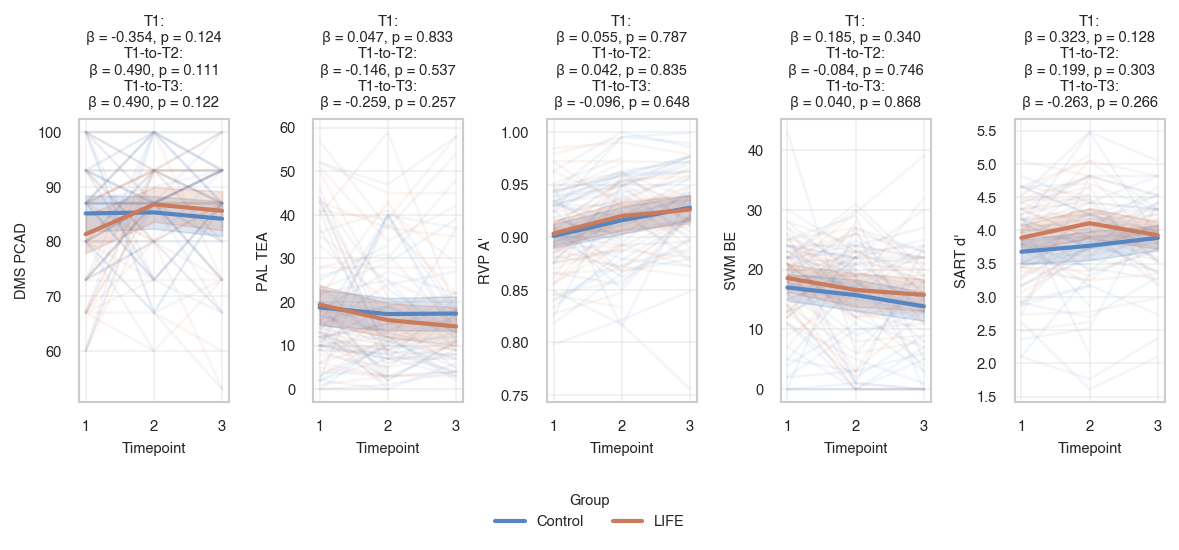

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   exponent_po
No. Observations:    221       Method:               REML       
No. Groups:          83        Scale:                0.1879     
Min. group size:     2         Log-Likelihood:       -284.4706  
Max. group size:     3         Converged:            Yes        
Mean group size:     2.7                                        
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             -0.057    0.148 -0.383 0.701 -0.346  0.233
tp[T.2]               -0.012    0.145 -0.080 0.937 -0.296  0.273
tp[T.3]               -0.072    0.137 -0.521 0.602 -0.340  0.197
age_bas               -0.193    0.111 -1.735 0.083 -0.411  0.025
tp[T.2]:age_bas        0.202    0.109  1.853 0.064 -0.012  0.417
tp[T.3]:age_bas        0.027    0.109  

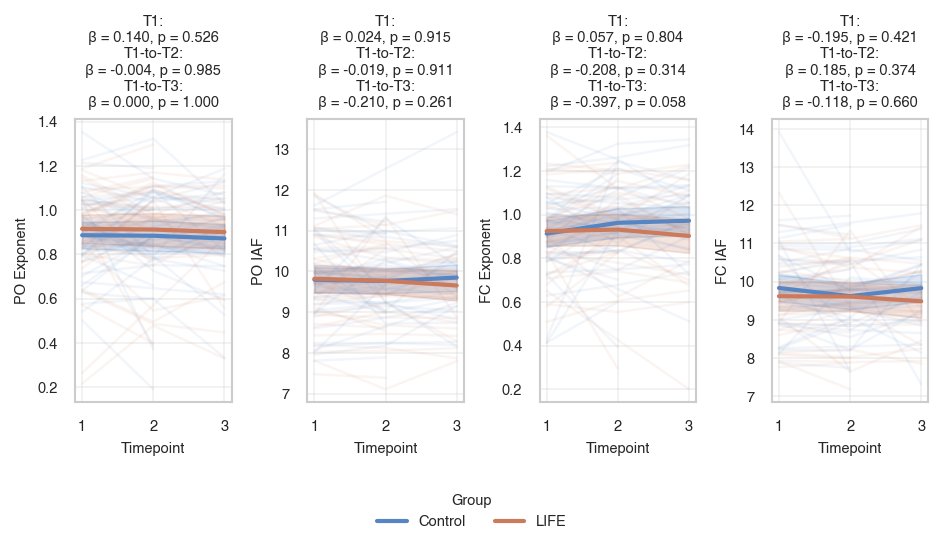

In [351]:
vars_dict = {
    'cog': {
        'DMSPCAD': 'DMS PCAD', 'PALTEA': 'PAL TEA', 'RVPA': "RVP A'", 'SWMBE': 'SWM BE', 'd_prime': "SART d'"
    },
    'eeg': {
        'exponent_po': 'PO Exponent', 'iaf_po': 'PO IAF', 'exponent_fc': 'FC Exponent', 'iaf_fc': 'FC IAF'
    }
}
colors = {'0.0': '#5785C1FF', '1.0': '#CB7A5CFF'} 
legend_dict = {0.0: 'Control', 1.0: 'LIFE'} 
sns.set_theme(font='Helvetica', context='paper', style='whitegrid')
plt.rc('grid', linestyle='-', alpha=0.3)
plt.rcParams.update({
    'font.size': 7, 'axes.titlesize': 7, 'axes.labelsize': 7, 'xtick.labelsize': 7,
    'ytick.labelsize': 7, 'legend.fontsize': 7, 'figure.dpi': 150
})

for type, vars in vars_dict.items():
    if type == 'cog':
        fig, axs = plt.subplots(1, 5, figsize=((40*5)/25.4, 80/25.4))
    else:
        fig, axs = plt.subplots(1, 4, figsize=((40*4)/25.4, 80/25.4))
    
    for i, (dv, dv_label) in enumerate(vars.items()):
        ax = axs[i]
            
        df_lme = df[['subject', 'tp', 'group_life', 'age', 'gender_f', 'education', 'handedness_r', dv]]
        df_lme = df_lme.sort_values(by=['subject', 'tp'])

        # keep only subjects with multiple timepoints and necessary data
        df_lme = df_lme.dropna()
        df_lme = df_lme[df_lme['subject'].isin(df_lme[df_lme['tp'] == 1]['subject'].unique())]
        df_lme = df_lme[df_lme.groupby('subject')['subject'].transform('count') > 1]
        df_lme['age_bas'] = df_lme.groupby('subject')['age'].transform('first')
        df_lme['education_bas'] = df_lme.groupby('subject')['education'].transform('first')
        df_lme['tp'] = df_lme['tp'].astype('category')

        # zscore
        cols_z = ['age_bas', 'gender_f', 'education_bas', 'handedness_r', dv]
        orig_means, orig_stds = df_lme[cols_z].mean(), df_lme[cols_z].std()
        df_lme_z = df_lme.copy()
        df_lme_z[cols_z] = df_lme_z[cols_z].apply(zscore)

        # Mixed-effects model with TP as a categorical predictor
        # formula = f"{dv} ~ age_bas + education_bas + gender_f + handedness_r + tp * group_life"
        formula = f"{dv} ~ tp * (age_bas + education_bas + gender_f + handedness_r + group_life)"
        model = smf.mixedlm(formula, data=df_lme_z, groups='subject', re_formula="~tp")
        results = model.fit()

        print(results.summary())

        # # Calculate and print R² values
        # r2_marg, r2_cond = calculate_r2_nakagawa(results)
        # print("\nNakagawa & Schielzeth R-squared values:")
        # print(f"Marginal R² = {r2_marg:.3f}")
        # print(f"Conditional R² = {r2_cond:.3f}\n")
            
        # dataframe for group and tp predictions
        pred_df = pd.DataFrame({
            'tp': np.repeat([1, 2, 3], 2),
            'group_life': np.tile([0.0, 1.0], 3)
        })
        for col in ['age_bas', 'education_bas', 'gender_f', 'handedness_r']:
            pred_df[col] = [df_lme_z[col].mean()] * 6

        pred_df['tp'] = pred_df['tp'].astype('category')
        pred_df['predicted'] = results.predict(pred_df)
        pred_df['predicted_orig'] = pred_df['predicted'] * orig_stds[dv] + orig_means[dv]

        # calculate confidence intervals
        design_matrix = np.asarray(patsy.dmatrix(formula.split('~')[1], data=pred_df))
        prediction_var = np.diag(design_matrix @ results.cov_params().iloc[:18, :18] @ design_matrix.T) # change the :10 if different formula
        se = np.sqrt(prediction_var)
        pred_df['ci_lower'] = (pred_df['predicted'] - 1.96 * se) * orig_stds[dv] + orig_means[dv]
        pred_df['ci_upper'] = (pred_df['predicted'] + 1.96 * se) * orig_stds[dv] + orig_means[dv]

        ### plotting
        
        # spaghetti plot
        for subject, group in df_lme.groupby('subject'):
            group_color = colors[str(group['group_life'].iloc[0])]  # Get group color
            ax.plot(
                group['tp'], group[dv],
                alpha=0.075, color=group_color, label='_nolegend_'
            )

        # prediction plot
        for group in [0.0, 1.0]:
            group_data = pred_df[pred_df['group_life'] == group]
            ax.plot(group_data['tp'], group_data['predicted_orig'], 
                    label=legend_dict[group], linewidth=2, 
                    color=colors[str(group)])
            ax.fill_between(group_data['tp'], 
                            group_data['ci_lower'],
                            group_data['ci_upper'],
                            alpha=0.2, color=colors[str(group)])

        # annotations
        tp1_idx = results.model.exog_names.index('group_life')
        tp1_b, tp1_p = results.params[tp1_idx], results.pvalues[tp1_idx]
        tp1_ptext = '< 0.001' if tp1_p < 0.001 else f'= {tp1_p:.3f}'
        
        tp2_idx = results.model.exog_names.index('tp[T.2]:group_life')
        tp2_b, tp2_p = results.params[tp2_idx], results.pvalues[tp2_idx]
        tp2_ptext = '< 0.001' if tp2_p < 0.001 else f'= {tp2_p:.3f}'
        
        tp3_idx = results.model.exog_names.index('tp[T.3]:group_life')
        tp3_b, tp3_p = results.params[tp3_idx], results.pvalues[tp3_idx]
        tp3_ptext = '< 0.001' if tp3_p < 0.001 else f'= {tp3_p:.3f}'

        ax.set_title(
            f'T1:\nβ = {tp1_b:.3f}, p {tp1_ptext}\n'
            f'T1-to-T2:\nβ = {tp2_b:.3f}, p {tp2_ptext}\n'
            f'T1-to-T3:\nβ = {tp3_b:.3f}, p {tp3_ptext}'
        )

        ax.set_xlabel('Timepoint')
        ax.set_ylabel(dv_label)
    plt.tight_layout()
    plt.legend(loc='lower center', ncol=2, title='Group', frameon=False, title_fontsize=7,
               bbox_to_anchor=(0.5, -0.15), bbox_transform=fig.transFigure)
    plt.savefig(os.path.join(plots_dir, f'LME_tp_{type}.pdf'), format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

Continuous time

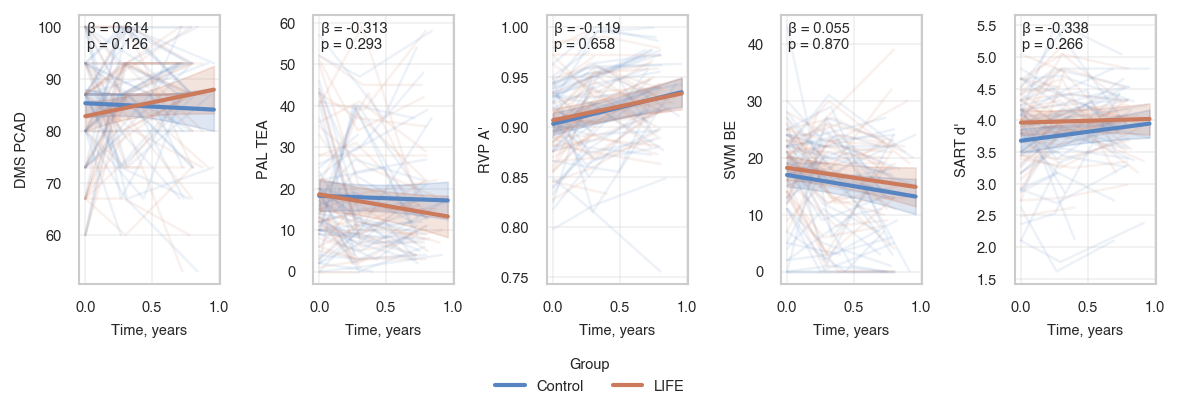

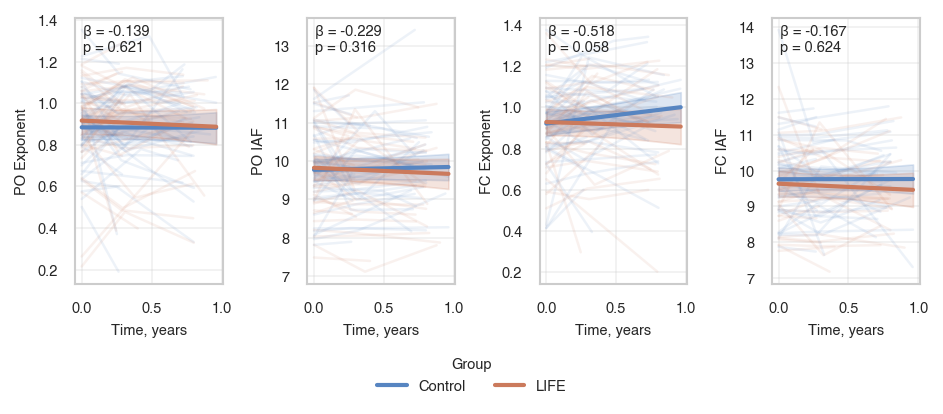

In [350]:
vars_dict = {
    'cog': {
        'DMSPCAD': 'DMS PCAD', 'PALTEA': 'PAL TEA', 'RVPA': "RVP A'", 'SWMBE': 'SWM BE', 'd_prime': "SART d'"
    },
    'eeg': {
        'exponent_po': 'PO Exponent', 'iaf_po': 'PO IAF', 'exponent_fc': 'FC Exponent', 'iaf_fc': 'FC IAF'
    }
}
colors = {'0.0': '#5785C1FF', '1.0': '#CB7A5CFF'} 
legend_dict = {0.0: 'Control', 1.0: 'LIFE'} 
sns.set_theme(font='Helvetica', context='paper', style='whitegrid')
plt.rc('grid', linestyle='-', alpha=0.3)
plt.rcParams.update({
    'font.size': 7, 'axes.titlesize': 7, 'axes.labelsize': 7, 'xtick.labelsize': 7,
    'ytick.labelsize': 7, 'legend.fontsize': 7, 'figure.dpi': 150
})

for type, vars in vars_dict.items():
    if type == 'cog':
        fig, axs = plt.subplots(1, 5, figsize=((40*5)/25.4, 60/25.4))
    else:
        fig, axs = plt.subplots(1, 4, figsize=((40*4)/25.4, 60/25.4))
    
    for i, (dv, dv_label) in enumerate(vars.items()):
        ax = axs[i]

        df_lme = df[[f'subject', 'tp', 'group_life', 'age', 'gender_f', 'education', 'handedness_r', dv]]

        df_lme = df_lme.sort_values(by=['subject', 'tp'])
        df_lme['time'] = df_lme.groupby('subject')['age'].transform(lambda x: x - x.iloc[0])
        df_lme['age_bas'] = df_lme.groupby('subject')['age'].transform('first')
        df_lme['education_bas'] = df_lme.groupby('subject')['education'].transform('first')
        
        df_lme = df_lme.dropna()
        df_lme = df_lme[df_lme['subject'].isin(df_lme[df_lme['tp'] == 1]['subject'].unique())]
        df_lme = df_lme[df_lme.groupby('subject')['subject'].transform('count') > 1]

        # zscore
        cols_z = ['age_bas', 'gender_f', 'education_bas', 'handedness_r', dv]
        orig_means, orig_stds = df_lme[cols_z].mean(), df_lme[cols_z].std()
        df_lme_z = df_lme.copy()
        df_lme_z[cols_z] = df_lme_z[cols_z].apply(zscore)
        
        # formula = f"{dv} ~ age_bas + education_bas + gender_f + handedness_r + time * group_life"
        formula = f"{dv} ~ time * (age_bas + education_bas + gender_f + handedness_r + group_life)"
        model = smf.mixedlm(formula, data=df_lme_z, groups='subject', re_formula='~time')
        results = model.fit()
        # print(results.summary())
        
        # calculate and print R² values
        # r2_marg, r2_cond = calculate_r2_nakagawa(results)
        # print("\nNakagawa & Schielzeth R-squared values:")
        # print(f"Marginal R² = {r2_marg:.3f}")
        # print(f"Conditional R² = {r2_cond:.3f}\n")

        # dataframe for group predictions
        time_grid = np.linspace(df_lme['time'].min(), df_lme['time'].max(), 100)
        predictions = []
        for group_life in df_lme['group_life'].unique():
            # calculate mean
            pred_df = pd.DataFrame({
                'time': time_grid,
                'group_life': group_life,
                'age_bas': [df_lme_z['age_bas'].mean()] * len(time_grid),
                'education_bas': [df_lme_z['education_bas'].mean()] * len(time_grid),
                'gender_f': [df_lme_z['gender_f'].mean()] * len(time_grid),
                'handedness_r': [df_lme_z['handedness_r'].mean()] * len(time_grid),
            })
            pred_df['predicted'] = results.predict(pred_df)
            pred_df['predicted_orig'] = pred_df['predicted'] * orig_stds[dv] + orig_means[dv]
            # calculate confidence intervals
            design_matrix = np.asarray(patsy.dmatrix(formula.split('~')[1], data=pred_df))
            prediction_var = np.diag(design_matrix @ results.cov_params().iloc[:12, :12] @ design_matrix.T) # change the :10 if different formula
            se = np.sqrt(prediction_var)
            pred_df['ci_lower'] = (pred_df['predicted'] - 1.96 * se) * orig_stds[dv] + orig_means[dv]
            pred_df['ci_upper'] = (pred_df['predicted'] + 1.96 * se) * orig_stds[dv] + orig_means[dv]

            predictions.append(pred_df)
        predictions = pd.concat(predictions)

        ### plotting

        # spaghetti plot
        for subject, group in df_lme.groupby('subject'):
            group_color = colors[str(group['group_life'].iloc[0])]
            ax.plot(group['time'], group[dv], alpha=0.1, color=group_color, label='_nolegend_')

        # prediction plot
        for group_life in predictions['group_life'].unique():
            group_data = predictions[predictions['group_life'] == group_life]
            ax.plot(group_data['time'], group_data['predicted_orig'],
                    label=legend_dict[group_life], linewidth=2, color=colors[str(group_life)])
            ax.fill_between(group_data['time'], group_data['ci_lower'], group_data['ci_upper'],
                            alpha=0.2, color=colors[str(group_life)])
        
        # interaction annotation
        interaction_idx = results.model.exog_names.index('time:group_life')
        beta = results.params[interaction_idx]
        pval = results.pvalues[interaction_idx]
        ptext = '< 0.001' if pval < 0.001 else f'= {pval:.3f}'
        ax.text(0.055, 0.975, f'β = {beta:.3f}\np {ptext}',
                transform=ax.transAxes, verticalalignment='top')

        ax.set_xlabel('Time, years')
        ax.set_ylabel(dv_label)
    plt.tight_layout()
    plt.legend(loc='lower center', ncol=2, title='Group', frameon=False, title_fontsize=7,
               bbox_to_anchor=(0.5, -0.15), bbox_transform=fig.transFigure)
    plt.savefig(os.path.join(plots_dir, f'LME_time_{type}.pdf'), format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()